In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np


In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def extract_features_resnet(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # ResNet expects 224x224
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # ResNet-specific preprocessing
    features = resnet_model.predict(x)
    features = features.flatten()
    return features


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/


'Colab Notebooks'	  'image captioning.gslides'
 dataset.zip		   ImageCaptioningModels
 Flickr8k_Dataset	  'Smart Grid System and Battery.pptx'
 image_captioning_backup


In [ ]:
import zipfile
import os

# Path to your zip file in Drive
zip_path = '/content/drive/MyDrive/dataset.zip'

# Where to extract it
extract_to = '/content/dataset'

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" Dataset extracted!")


 Dataset extracted!


In [ ]:
!ls /content/drive/MyDrive/Flickr8k_Dataset


captions.txt  Images


In [ ]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/Flickr8k_Dataset/captions.txt")
data.head()  # to peek at the first few lines


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
from textwrap import wrap
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Flickr8k_Dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

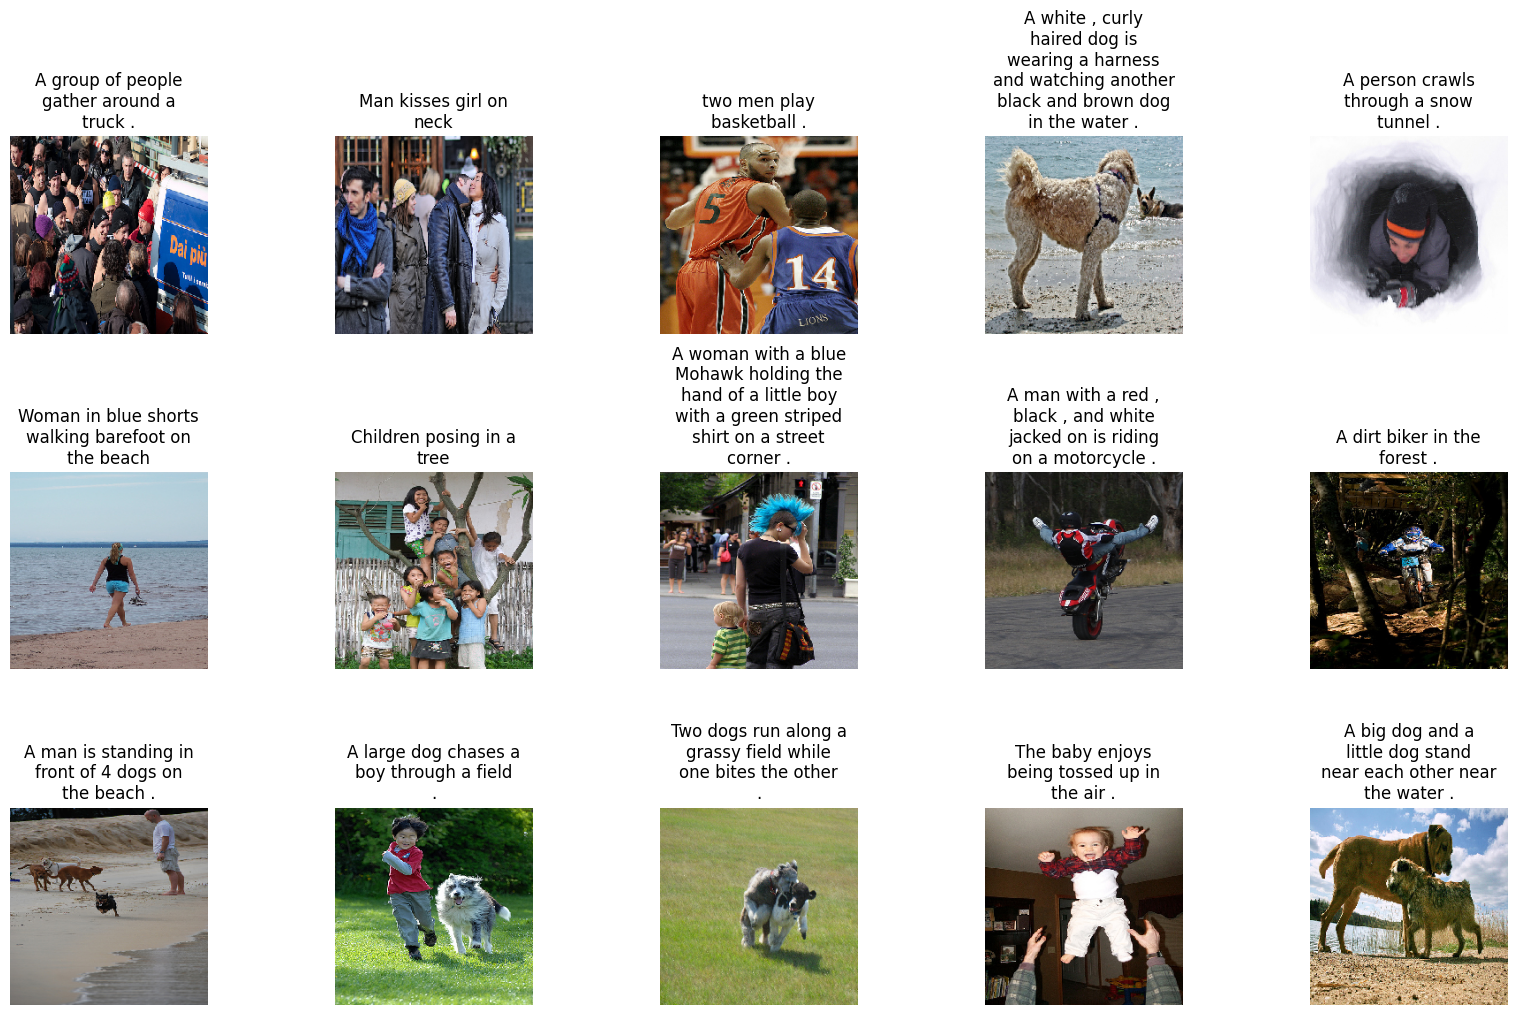

In [ ]:
display_images(data.sample(15))

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [ ]:
image_path = "/content/dataset/Images"


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

Model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    feature = Model.predict(img, verbose=0)
    features[image] = feature.flatten()


100%|██████████| 8091/8091 [52:31<00:00,  2.57it/s]


In [ ]:
import pickle
import os

backup_dir = '/content/drive/MyDrive/image_captioning_backup'

with open(os.path.join(backup_dir, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

print(" Features loaded successfully!")

 Features loaded successfully!


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train_df = data[data['image'].isin(train_images)]
val_df = data[data['image'].isin(val_images)]

train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle324
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y



In [ ]:
input1 = Input(shape=(2048,)) #Image Embedding
input2 = Input(shape=(38,)) #Word Embedding
img_features = Dense(512, activation='relu')(input1)
img_features1 = Dense(256, activation= 'relu')(img_features)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features1)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
#attention_output = Attention()(merged)
attention_layer = keras.layers.MultiHeadAttention(
    num_heads=8,
    key_dim=32,
    dropout=0.3
)
attention_output = attention_layer(query=merged, key=merged, value=merged)
sentence_features = LSTM(512)(attention_output)
x = Dropout(0.3)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

caption_model = tf.keras.Model(inputs=[input1,input2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


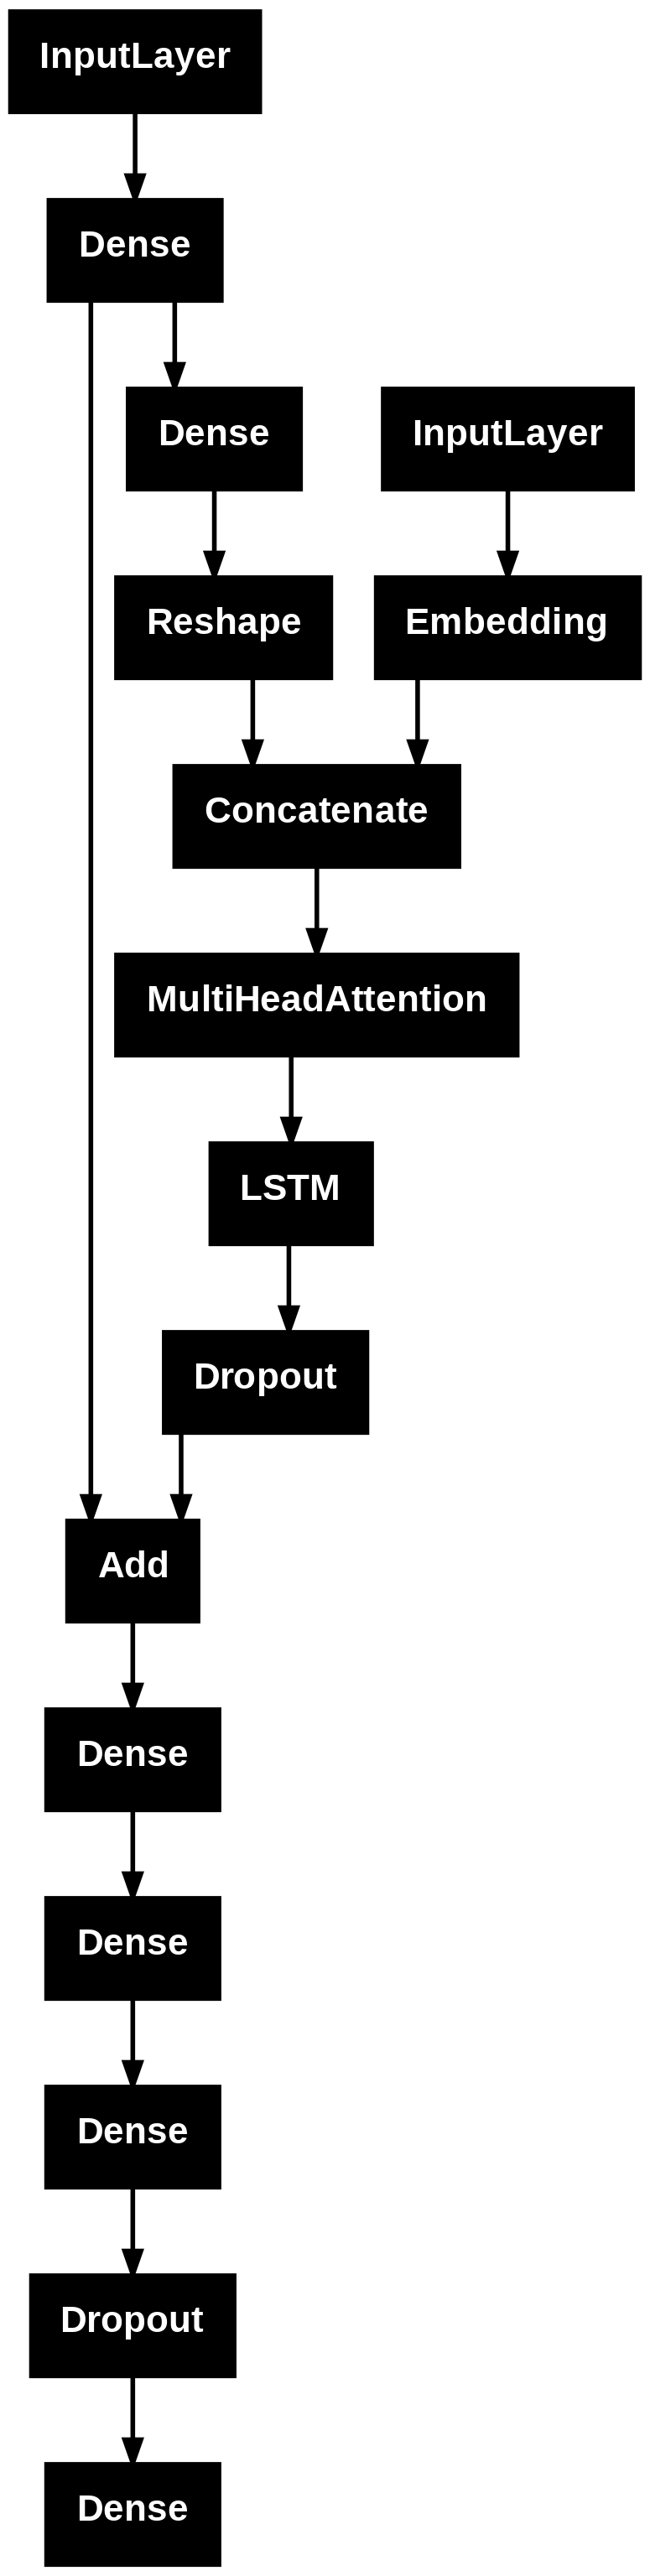

In [ ]:
plot_model(caption_model)

In [ ]:
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)


In [ ]:
train_generator = CustomDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=38,
    features=features,
    shuffle=True
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=38,
    features=features,
    shuffle=False
)


In [ ]:
print(type(val_df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print("train_generator max_length:", train_generator.max_length)
print("validation_generator max_length:", validation_generator.max_length)


train_generator max_length: 38
validation_generator max_length: 38


In [ ]:
from google.colab import drive
import os

# Define the folder path
drive_path = '/content/drive/MyDrive/ImageCaptioningModels'

# Make the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)
print(f"Folder created at: {drive_path}")


Folder created at: /content/drive/MyDrive/ImageCaptioningModels


In [ ]:
import os

drive_path = '/content/drive/MyDrive/ImageCaptioningModels'
os.makedirs(drive_path, exist_ok=True)
print(f"Saving models to: {drive_path}")


Saving models to: /content/drive/MyDrive/ImageCaptioningModels


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = "model_epoch_{epoch:02d}.keras"

checkpoint = ModelCheckpoint(
    filepath=os.path.join(drive_path, 'model_epoch_{epoch:02d}.keras'),
    monitor='val_loss',
    save_freq='epoch',
    save_best_only=False,  # change to True if you want only best saved
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=4,
    verbose=1,
    factor=0.2,
    min_lr=1e-5
)


In [ ]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer loaded!  Vocab size:", vocab_size)


Tokenizer loaded!  Vocab size: 8485


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Flickr8k_Dataset/captions.txt')

data.columns = ['image', 'caption']

data['image'] = data['image'].apply(lambda x: x.split('.')[0] + '.jpg')

captions_dict = data.groupby('image')['caption'].apply(list).to_dict()


In [ ]:
all_captions = []
for caps in captions_dict.values():
    all_captions.extend(caps)

max_length = max(len(caption.split()) for caption in all_captions)
print("Max caption length:", max_length)


Max caption length: 38


In [ ]:
import pickle

backup_dir = '/content/drive/MyDrive/image_captioning_backup'

with open(f'{backup_dir}/features.pkl', 'rb') as f:
    features = pickle.load(f)

print(f" Loaded features for {len(features)} images")

 Loaded features for 8091 images


In [ ]:
with open('/content/drive/MyDrive/image_captioning_backup/features.pkl', 'wb') as f:
    pickle.dump(features, f)


In [ ]:
import pickle

with open('/content/drive/MyDrive/image_captioning_backup/features.pkl', 'rb') as f:
    features = pickle.load(f)


In [ ]:
missing = [k for k in captions_dict.keys() if k not in features]
print("Missing image features:", len(missing))


Missing image features: 0


In [ ]:
from sklearn.model_selection import train_test_split

keys = list(captions_dict.keys())
train_keys, val_keys = train_test_split(keys, test_size=0.2, random_state=42)

train_captions = {k: captions_dict[k] for k in train_keys}
val_captions = {k: captions_dict[k] for k in val_keys}

train_features = {k: features[k] for k in train_keys}
val_features = {k: features[k] for k in val_keys}


In [ ]:
x, y = train_generator[0]
print(type(x), [arr.shape for arr in x])
print(type(y), y.shape)


<class 'tuple'> [(3543, 2048), (3543, 38)]
<class 'numpy.ndarray'> (3543, 8485)


In [ ]:
caption_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy'],
    run_eagerly=True
)


In [ ]:
print(isinstance(train_generator, Sequence))


True


In [ ]:
x, y = train_generator[0]
print(type(x))
print(type(y))
print(isinstance(x, np.ndarray))
print(isinstance(y, np.ndarray))


<class 'tuple'>
<class 'numpy.ndarray'>
False
True


In [ ]:
print(type(x[0]), x[0].shape)
print(type(x[1]), x[1].shape)


<class 'numpy.ndarray'> (3543, 2048)
<class 'numpy.ndarray'> (3543, 38)


In [ ]:
print(type(train_generator))
print(isinstance(train_generator, tf.keras.utils.Sequence))


<class '__main__.CustomDataGenerator'>
True


In [ ]:
from tensorflow.keras.utils import Sequence
print(isinstance(train_generator, Sequence))


True


In [ ]:
print(type(caption_model))


<class 'keras.src.models.functional.Functional'>


In [ ]:
for input_tensor in caption_model.inputs:
    print(input_tensor.name, input_tensor.shape, input_tensor.dtype)


keras_tensor_528 (None, 2048) float32
keras_tensor_529 (None, 38) float32


In [ ]:
import numpy as np

dummy_img = np.random.rand(1, 1536).astype(np.float32)

dummy_seq = np.random.randint(low=1, high=vocab_size, size=(1, max_length)).astype(np.int32)

print("dummy_img shape:", dummy_img.shape, "dtype:", dummy_img.dtype)
print("dummy_seq shape:", dummy_seq.shape, "dtype:", dummy_seq.dtype)


dummy_img shape: (1, 1536) dtype: float32
dummy_seq shape: (1, 38) dtype: int32


In [ ]:
dummy_img = np.random.rand(1, 2048).astype(np.float32)
dummy_seq = np.random.randint(low=1, high=vocab_size, size=(1, max_length)).astype(np.int32)

caption_model([dummy_img, dummy_seq])


<tf.Tensor: shape=(1, 8485), dtype=float32, numpy=
array([[0.00011069, 0.00012805, 0.00011381, ..., 0.00011964, 0.000112  ,
        0.00012313]], dtype=float32)>

In [ ]:
(x, y) = train_generator[0]
print([arr.shape for arr in x])
print(y.shape)


[(3543, 2048), (3543, 38)]
(3543, 8485)


In [ ]:
for img_id, feat in train_features.items():
    print(img_id, feat.shape)


3393152604_27bd1037f2.jpg (2048,)
3549673305_4dfd44e04a.jpg (2048,)
3181328245_7c04ce1691.jpg (2048,)
2393410666_b8c20fff61.jpg (2048,)
239807547_4923efc821.jpg (2048,)
1388373425_3c72b56639.jpg (2048,)
3561543598_3c1b572f9b.jpg (2048,)
3477369101_8e0c61d8f4.jpg (2048,)
3564385317_1bf5094068.jpg (2048,)
2766926202_4201bf2bf9.jpg (2048,)
3394750987_a32ecc477e.jpg (2048,)
441921713_1cafc7d7d2.jpg (2048,)
2403376030_903521c371.jpg (2048,)
2635905544_dbc65d0622.jpg (2048,)
270809922_043e3bef06.jpg (2048,)
597543181_6a85ef4c17.jpg (2048,)
3482974845_db4f16befa.jpg (2048,)
2874728371_ccd6db87f3.jpg (2048,)
2913965136_2d00136697.jpg (2048,)
241347689_d0b1ac297d.jpg (2048,)
2272750492_91e8f67328.jpg (2048,)
197504190_fd1fc3d4b7.jpg (2048,)
416960865_048fd3f294.jpg (2048,)
837893113_81854e94e3.jpg (2048,)
3368671163_0171259581.jpg (2048,)
433855742_c2a6fda763.jpg (2048,)
2788945468_74a9618cfa.jpg (2048,)
2894217628_f1a4153dca.jpg (2048,)
542269487_5d77b363eb.jpg (2048,)
3520321387_710ab74cda.jp

In [ ]:
import os

for root, dirs, files in os.walk("/"):
    for name in files:
        if name.endswith(".keras") or name.endswith(".h5"):
            print(os.path.join(root, name))


/root/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/root/.julia/packages/FileIO/ePyCW/test/files/file1.h5
/root/.julia/packages/FileIO/ePyCW/test/files/h5ad.h5
/root/.julia/packages/FileIO/ePyCW/test/files/file2.h5
/usr/local/lib/python3.11/dist-packages/tables/nodes/tests/test_filenode_v1.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_unsupptype.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_i32be.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/nested-type-with-gaps.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/Tables_lzo1.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_i64be.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/bug-idx.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/Tables_lzo2_shuffle.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/time-table-vlarray-1_x.h5
/usr/local/lib/python3.11/dist-packages/tables/tests/smpl_i32le.h5
/usr/local/lib/python3.11/dist-packages/tables

In [ ]:
history = caption_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    initial_epoch=1,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 49/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1443 - loss: 5.4657
Epoch 49: saving model to /content/drive/MyDrive/ImageCaptioningModels/model_epoch_49.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 6774s 13s/step - accuracy: 0.1444 - loss: 5.4646 - val_accuracy: 0.2556 - val_loss: 4.1236 - learning_rate: 0.0010
Epoch 50/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2602 - loss: 4.0592
Epoch 50: saving model to /content/drive/MyDrive/ImageCaptioningModels/model_epoch_50.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 6714s 13s/step - accuracy: 0.2602 - loss: 4.0591 - val_accuracy: 0.2860 - val_loss: 3.8247 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.


In [ ]:
sample_image = list(features.keys())[0]
print("Image name:", sample_image)
print("Feature shape:", features[sample_image].shape)
print("Feature vector:", features[sample_image])


Image name: 1000268201_693b08cb0e.jpg
Feature shape: (2048,)
Feature vector: [0.06536549 0.1678271  0.32518435 ... 0.05111533 0.32817906 1.0043344 ]
